In [73]:
from mod1 import *
df = select_stock('삼성전자','2019-01-01')
df[240:300]

,Date,Code,Name,Open,High,Low,Volume,Close
240,2019-12-20,005930,삼성전자,56100,56500,55600,12074682,56000
241,2019-12-23,005930,삼성전자,56100,56400,55100,9490480,55500
242,2019-12-24,005930,삼성전자,55600,55700,54800,9187223,55000
243,2019-12-26,005930,삼성전자,54700,55400,54400,9573327,55400
244,2019-12-27,005930,삼성전자,55700,56900,55500,12293167,56500
245,2019-12-30,005930,삼성전자,56200,56600,55700,8346433,55800
246,2020-01-02,005930,삼성전자,55500,56000,55000,12756901,55200
247,2020-01-03,005930,삼성전자,56000,56600,54900,15307310,55500
248,2020-01-06,005930,삼성전자,54900,55600,54600,10278951,55500
249,2020-01-07,005930,삼성전자,55700,56400,55600,10009778,55800


In [41]:
df = df.set_index('Date')
df

,Code,Name,Open,High,Low,Volume,Close
Date,,,,,,,
2020-01-02,036640,HRS,2675,2675,2640,70066,2655
2020-01-03,036640,HRS,2655,2690,2655,75018,2680
2020-01-06,036640,HRS,2650,2680,2600,74714,2610
2020-01-07,036640,HRS,2605,2645,2605,43743,2635
2020-01-08,036640,HRS,2630,3025,2545,5063029,2800
...,...,...,...,...,...,...,...
2020-05-18,036640,HRS,2545,3180,2520,5858871,3115
2020-05-19,036640,HRS,3065,3365,2960,2476943,3140
2020-05-20,036640,HRS,3145,3640,3110,5273166,3430


In [45]:
df.loc[:10]

,Code,Name,Open,High,Low,Volume,Close
Date,,,,,,,
2020-01-02,036640,HRS,2675,2675,2640,70066,2655
2020-01-03,036640,HRS,2655,2690,2655,75018,2680
2020-01-06,036640,HRS,2650,2680,2600,74714,2610
2020-01-07,036640,HRS,2605,2645,2605,43743,2635
2020-01-08,036640,HRS,2630,3025,2545,5063029,2800
2020-01-09,036640,HRS,2580,2615,2455,833727,2615
2020-01-10,036640,HRS,2615,2645,2525,340601,2530
2020-01-13,036640,HRS,2520,2550,2510,150556,2520
2020-01-14,036640,HRS,2530,2545,2505,93895,2520


In [49]:
df.iloc[:10]

,Code,Name,Open,High,Low,Volume,Close
Date,,,,,,,
2020-01-02,036640,HRS,2675,2675,2640,70066,2655
2020-01-03,036640,HRS,2655,2690,2655,75018,2680
2020-01-06,036640,HRS,2650,2680,2600,74714,2610
2020-01-07,036640,HRS,2605,2645,2605,43743,2635
2020-01-08,036640,HRS,2630,3025,2545,5063029,2800
2020-01-09,036640,HRS,2580,2615,2455,833727,2615
2020-01-10,036640,HRS,2615,2645,2525,340601,2530
2020-01-13,036640,HRS,2520,2550,2510,150556,2520
2020-01-14,036640,HRS,2530,2545,2505,93895,2520


In [59]:
df.index[0]

datetime.date(2020, 1, 2)

In [51]:
df.index

Index([2020-01-02, 2020-01-03, 2020-01-06, 2020-01-07, 2020-01-08, 2020-01-09,
       2020-01-10, 2020-01-13, 2020-01-14, 2020-01-15, 2020-01-16, 2020-01-17,
       2020-01-20, 2020-01-21, 2020-01-22, 2020-01-23, 2020-01-28, 2020-01-29,
       2020-01-30, 2020-01-31, 2020-02-03, 2020-02-04, 2020-02-05, 2020-02-06,
       2020-02-07, 2020-02-10, 2020-02-11, 2020-02-12, 2020-02-13, 2020-02-14,
       2020-02-17, 2020-02-18, 2020-02-19, 2020-02-20, 2020-02-21, 2020-02-24,
       2020-02-25, 2020-02-26, 2020-02-27, 2020-02-28, 2020-03-02, 2020-03-03,
       2020-03-04, 2020-03-05, 2020-03-06, 2020-03-09, 2020-03-10, 2020-03-11,
       2020-03-12, 2020-03-13, 2020-03-16, 2020-03-17, 2020-03-18, 2020-03-19,
       2020-03-20, 2020-03-23, 2020-03-24, 2020-03-25, 2020-03-26, 2020-03-27,
       2020-03-30, 2020-03-31, 2020-04-01, 2020-04-02, 2020-04-03, 2020-04-06,
       2020-04-07, 2020-04-08, 2020-04-09, 2020-04-10, 2020-04-13, 2020-04-14,
       2020-04-16, 2020-04-17, 2020-04-20, 2020-04-2

In [67]:
df.loc[' 2020-01'].head()

KeyError: ' 2020-01'

# Backtrader 

## 주식Data를 select_stock로 불러서 백테스트할때

Starting Portfolio Value: 1000000.00
2019-01-30, BUY EXECUTED, Price: 44800.00, Size:    21.00 Cost: 940800.00, Comm:     0.00
2019-03-04, SELL EXECUTED, 46000.00, Size:   -21.00 Cost: 940800.00, Comm    0.00
2019-03-22, Order Canceled/Margin/Rejected
2019-03-25, BUY EXECUTED, Price: 45300.00, Size:    22.00 Cost: 996600.00, Comm:     0.00
2019-04-19, SELL EXECUTED, 45750.00, Size:   -22.00 Cost: 996600.00, Comm    0.00
2019-04-30, BUY EXECUTED, Price: 46000.00, Size:    22.00 Cost: 1012000.00, Comm:     0.00
2019-05-02, SELL EXECUTED, 45500.00, Size:   -22.00 Cost: 1012000.00, Comm    0.00
2019-05-24, BUY EXECUTED, Price: 43800.00, Size:    23.00 Cost: 1007400.00, Comm:     0.00
2019-05-27, SELL EXECUTED, 42500.00, Size:   -23.00 Cost: 1007400.00, Comm    0.00
2019-06-04, BUY EXECUTED, Price: 43400.00, Size:    22.00 Cost: 954800.00, Comm:     0.00
2019-07-09, SELL EXECUTED, 44850.00, Size:   -22.00 Cost: 954800.00, Comm    0.00
2019-07-11, BUY EXECUTED, Price: 46350.00, Size:    22.0

<IPython.core.display.Javascript object>


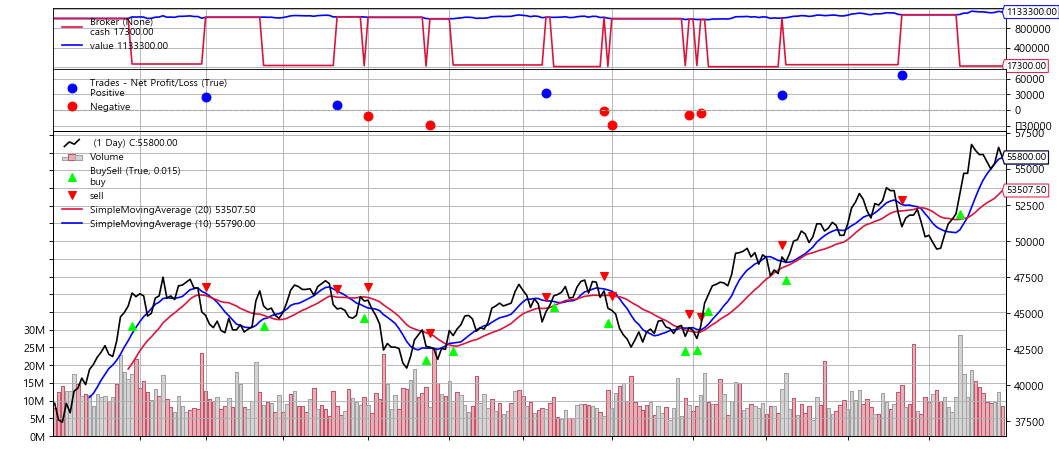

In [1]:
##  20일 이동 평균선 추세매매 (20MA > Close : Buy,  20MA < Close : Sell)

from mod1 import *
import datetime
import backtrader as bt

# Create a subclass of Strategy to define the indicators and logic
class Momentum(bt.Strategy):
    # list of parameters which are configurable for the strategy
    params = dict(
        pfast=10,  # period for the fast moving average
        pslow=20  # period for the slow moving average
    )

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.smaSlow = bt.ind.SimpleMovingAverage(period=self.p.pslow)
        self.smaFast = bt.ind.SimpleMovingAverage(period=self.p.pfast)
        self.order = None

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def notify_order(self, order):
        # 1. If order is submitted/accepted, do nothing
        if order.status in [order.Submitted, order.Accepted]:
            return
        # 2. If order is buy/sell executed, report price executed
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, Price: {0:8.2f}, Size: {1:8.2f} Cost: {2:8.2f}, Comm: {3:8.2f}'.format(
                    order.executed.price,
                    order.executed.size,
                    order.executed.value,
                    order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:
                self.log('SELL EXECUTED, {0:8.2f}, Size: {1:8.2f} Cost: {2:8.2f}, Comm{3:8.2f}'.format(
                    order.executed.price,
                    order.executed.size,
                    order.executed.value,
                    order.executed.comm))

            self.bar_executed = len(self)  # when was trade executed
        # 3. If order is canceled/margin/rejected, report order canceled
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def next(self):
        cash = self.broker.get_cash()
        value = self.broker.get_value()
        size = int(cash / self.data.close[0])
        # Order가 Pending인지 확인, 그렇다면 다시 주문할 수 없음
        if self.order:
            return

        if not self.position:  # not in the market
            if self.smaSlow < self.data.close[0]:
                self.order = self.buy(size=size)

        elif self.getposition().size > 0: #in the market
            if self.smaSlow > self.data.close[0]:
                self.order = self.sell(size=self.getposition().size)

def run(args=None):
    cerebro = bt.Cerebro()  # create a "Cerebro" engine instance
    cerebro.broker.setcash(1000000) #초기자금

    df = select_stock('삼성전자','2019-01-01')
    df = df.iloc[:246]
    df["Date"] = pd.to_datetime(df["Date"])  ###  아주 중요!! pandas.core.series.Series DATA를 datatime object numpy로 돌려줌
    df = df.set_index(df['Date'])
    data = bt.feeds.PandasData(dataname=df, open='Open',close='Close')

    cerebro.adddata(data) #데이터 삽입
    cerebro.addstrategy(Momentum) #전략적용
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.run() #수행
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.plot() #plot

if __name__ == '__main__':
    run()

Starting Portfolio Value: 1000000.00
2019-03-04, Order Canceled/Margin/Rejected
2019-03-05, BUY EXECUTED, Price: 44600.00, Size:    22.00 Cost: 981200.00, Comm:     0.00
2019-03-22, SELL EXECUTED, 46850.00, Size:   -22.00 Cost: 981200.00, Comm    0.00
2019-04-19, Order Canceled/Margin/Rejected
2019-04-22, BUY EXECUTED, Price: 45400.00, Size:    23.00 Cost: 1044200.00, Comm:     0.00
2019-04-30, SELL EXECUTED, 46000.00, Size:   -23.00 Cost: 1044200.00, Comm    0.00
2019-05-02, BUY EXECUTED, Price: 45500.00, Size:    23.00 Cost: 1046500.00, Comm:     0.00
2019-05-24, SELL EXECUTED, 43800.00, Size:   -23.00 Cost: 1046500.00, Comm    0.00
2019-05-27, BUY EXECUTED, Price: 42500.00, Size:    23.00 Cost: 977500.00, Comm:     0.00
2019-06-04, SELL EXECUTED, 43400.00, Size:   -23.00 Cost: 977500.00, Comm    0.00
2019-07-09, BUY EXECUTED, Price: 44850.00, Size:    23.00 Cost: 1031550.00, Comm:     0.00
2019-07-11, SELL EXECUTED, 46350.00, Size:   -23.00 Cost: 1031550.00, Comm    0.00
2019-07-30,

<IPython.core.display.Javascript object>


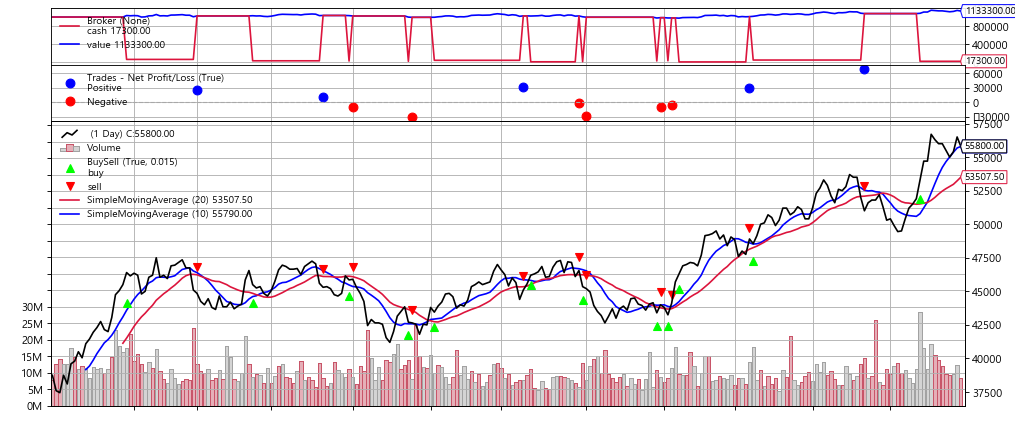

In [1]:
##  20일 이동 평균선 역추세매매 (20MA > Close : Sell,  20MA < Close : Buy)

from mod1 import *
import datetime
import backtrader as bt

# Create a subclass of Strategy to define the indicators and logic
class Momentum(bt.Strategy):
    # list of parameters which are configurable for the strategy
    params = dict(
        pfast=10,  # period for the fast moving average
        pslow=20  # period for the slow moving average
    )

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.smaSlow = bt.ind.SimpleMovingAverage(period=self.p.pslow)
        self.smaFast = bt.ind.SimpleMovingAverage(period=self.p.pfast)
        self.order = None

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def notify_order(self, order):
        # 1. If order is submitted/accepted, do nothing
        if order.status in [order.Submitted, order.Accepted]:
            return
        # 2. If order is buy/sell executed, report price executed
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, Price: {0:8.2f}, Size: {1:8.2f} Cost: {2:8.2f}, Comm: {3:8.2f}'.format(
                    order.executed.price,
                    order.executed.size,
                    order.executed.value,
                    order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:
                self.log('SELL EXECUTED, {0:8.2f}, Size: {1:8.2f} Cost: {2:8.2f}, Comm{3:8.2f}'.format(
                    order.executed.price,
                    order.executed.size,
                    order.executed.value,
                    order.executed.comm))

            self.bar_executed = len(self)  # when was trade executed
        # 3. If order is canceled/margin/rejected, report order canceled
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def next(self):
        cash = self.broker.get_cash()
        value = self.broker.get_value()
        size = int(cash / self.data.close[0])
        # Order가 Pending인지 확인, 그렇다면 다시 주문할 수 없음
        if self.order:
            return

        if not self.position:  # not in the market
            if self.smaSlow > self.data.close[0]:
                self.order = self.buy(size=size)

        elif self.getposition().size > 0: #in the market
            if self.smaSlow < self.data.close[0]:
                self.order = self.sell(size=self.getposition().size)
                
def run(args=None):
    cerebro = bt.Cerebro()  # create a "Cerebro" engine instance
    cerebro.broker.setcash(1000000) #초기자금

    df = select_stock('삼성전자','2019-01-01')
    df = df.iloc[:246]
    df["Date"] = pd.to_datetime(df["Date"])  ###  아주 중요!! pandas.core.series.Series DATA를 datatime object numpy로 돌려줌
    df = df.set_index(df['Date'])
    data = bt.feeds.PandasData(dataname=df, open='Open',close='Close')

    cerebro.adddata(data) #데이터 삽입
    cerebro.addstrategy(Momentum) #전략적용
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.run() #수행
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.plot() #plot

if __name__ == '__main__':
    run()

## 주식Data를 text로 불러서 백테스트할때

In [77]:
import datetime
import backtrader as bt


# Create a subclass of Strategy to define the indicators and logic

class SmaCross(bt.Strategy):
    # list of parameters which are configurable for the strategy
    params = dict(
        pfast=10,  # period for the fast moving average
        pslow=30   # period for the slow moving average
    )

    def __init__(self):
        sma1 = bt.ind.SMA(period=self.p.pfast)  # fast moving average
        sma2 = bt.ind.SMA(period=self.p.pslow)  # slow moving average
        self.crossover = bt.ind.CrossOver(sma1, sma2)  # crossover signal

    def next(self):
        if not self.position:  # not in the market
            if self.crossover > 0:  # if fast crosses slow to the upside
                self.buy()  # enter long

        elif self.crossover < 0:  # in the market & cross to the downside
            self.close()  # close long position


cerebro = bt.Cerebro()  # create a "Cerebro" engine instance

# Create a data feed
#homepath = os.getenv('c:\\Users\\kkang\notebook\\Git\\first_module')
datapath = ('./orcl-1995-2014.txt')

data = bt.feeds.YahooFinanceCSVData(
    dataname=datapath,
    fromdate=datetime.datetime(2000,1,1),
    todate = datetime.datetime(2000,12,31),
    reverse=False)

cerebro.adddata(data)  # Add the data feed

cerebro.addstrategy(SmaCross)  # Add the trading strategy
cerebro.run()  # run it all
cerebro.plot(style='candlestick')  # and plot it with a single command

[[<Figure size 576x432 with 5 Axes>]]

In [21]:
type(data)

backtrader.feeds.yahoo.YahooFinanceCSVData

In [ ]:
##  기간동안 낙폭 과대종목 검색

import time
from  mod1 import *

start = time.time()  # 시작 시간 저장

def all_stock_period(date1, date2='2021-01-01'):
    select_query = "select * from market_good where Date >=  "
    var = select_query +"'"+date1+"'"  +" "+ 'and Date <=' + "'"+date2+"'"
    df = pd.read_sql(var, engine)
    return df


df = all_stock_period('2020-02-20','2020-03-25')
df_uniq = df['Name'].unique()
df_uniq_list=df_uniq.tolist()

min_data = []
for x in df_uniq_list:
    min_value = min(df[df['Name']== x ].Close)
    min_data.append(min_value)

min_close = pd.DataFrame(min_data)

df_a=pd.DataFrame(df_uniq)


df_first=pd.DataFrame()
df_first['Name']=df_a[0]
df_first['Close']=min_close[0]
df_to = all_stock('2020-05-21')
df_last=df_to[['Name','Close']]
df = pd.merge(df_first,df_last,on='Name')

df['diff']=df['Close_y']/df['Close_x']
df.head()

close_diff_df =  df.sort_values(["diff"],ascending=True)
close_diff_df.head()

close_diff_df.to_excel("d:\\b_9.xlsx")
print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

In [ ]:
## 개별종목분석

from mod1 import *

def close_ma_vol(df,select1,select2,select3):
    ma(df)

    source = MinMaxScaler()
    data = source.fit_transform(df[['close',select1,select2,select3]].values)
    df1 = pd.DataFrame(data)
    df1.columns=['close',select1,select2,select3]
    df1 = df1.set_index(df['date'])
    df1.plot(figsize=(16,4))
    plt.title(df['name'][0])
    plt.grid(True)
    plt.show()    

name=['디엔에프','모트렉스','푸드나무','상보','아난티','손오공','한컴위드']

for i in name:
    df = select_stock(i,'2018-01-01')
    close_ma_vol(df,'ma60','ma120','volume')

In [ ]:
##  거래량 증가 관심종목 분석
from mod1 import *

def volume_group_analysis(path_volume,select_day):
    select_day = '2020-04-27'
    date = '2020-01-01'
    name = pd.read_excel(path_volume+select_day+'.xlsx', encoding='utf-8',index_col=0)
    name_all = name['Name']
    name_all = name_all.to_list()
    name = name[:5]

    for i in name_all:
        select_query = "select Date,Volume,Close from market where Name= "
        date_query = "Date > "
        var = select_query +"'"+i+"'"+" "+"&&"+" "+date_query+"'"+date+"'" 
        df = pd.read_sql(var, engine)
        df[['Volume','Close']] = df[['Volume','Close']].astype(float) #  TA-Lib로 평균을 구하려면 실수로 만들어야 함
        df.columns=df.columns.str.lower()

        talib_ma120 = ta.MA(df, timeperiod=20)
        df['ma20'] = talib_ma120

        source = MinMaxScaler()
        data = source.fit_transform(df[['close','volume','ma20']].values)
        df1 = pd.DataFrame(data)
        df1.columns=['close','volume','ma20']
        df1 = df1.set_index(df['date'])
        df1.plot(figsize=(16,2))
        plt.title(i)
        plt.show()
               
volume_group_analysis(path_price,'2020-04-28')

In [ ]:
##  가격 증가 관심종목 분석

from mod1 import *

def price_group_analysis(path_price,select_day):
    #select_day = '2020-04-27'
    date = '2020-01-01'
    name = pd.read_excel(path_volume+select_day+'.xlsx', encoding='utf-8',index_col=0)
    name_all = name['Name']
    name_all = name_all.to_list()
    name = name[:5]

    for i in name_all:
        select_query = "select Date,Volume,Close from market where Name= "
        date_query = "Date > "
        var = select_query +"'"+i+"'"+" "+"&&"+" "+date_query+"'"+date+"'" 
        df = pd.read_sql(var, engine)
        df[['Volume','Close']] = df[['Volume','Close']].astype(float) #  TA-Lib로 평균을 구하려면 실수로 만들어야 함
        df.columns=df.columns.str.lower()

        talib_ma120 = ta.MA(df, timeperiod=20)
        df['ma20'] = talib_ma120

        source = MinMaxScaler()
        data = source.fit_transform(df[['close','volume','ma20']].values)
        df1 = pd.DataFrame(data)
        df1.columns=['close','volume','ma20']
        df1 = df1.set_index(df['date'])
        df1.plot(figsize=(16,2))
        plt.title(i)
        plt.show()

price_group_analysis(path_price,'2020-04-27')

# stock_prediction

# first

In [ ]:
###  Keras_LSTM_Stock_Prediction#1

from mod1 import *
import math
import tensorflow as tf

df = select_stock('hrs','2020-01-01')
df=df[['Open','High','Close']]

df['High'] = df['High'] / 100000
df['Open'] = df['Open'] / 100000
df['Close'] = df['Close'] / 100000
df.head(5)

window = 5
amount_of_features = len(df.columns)
data = df.values #pd.DataFrame(stock)
sequence_length = window + 1
result = []

for index in range(len(data) - sequence_length):
    result.append(data[index: index + sequence_length])

result = np.array(result)



row = round(0.9 * result.shape[0])
train = result[:int(row), :]
x_train = train[:, :-1]
y_train = train[:, -1][:,-1]
x_test = result[int(row):, :-1]
y_test = result[int(row):, -1][:,-1]

#x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
#x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("X_test", x_test.shape)
print("y_test", y_test.shape)


d = 0.2
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape=(window, 3), return_sequences=True))
model.add(tf.keras.layers.Dropout(d))
model.add(tf.keras.layers.LSTM(64, input_shape=(window, 3), return_sequences=False))
model.add(tf.keras.layers.Dropout(d))
model.add(tf.keras.layers.Dense(16,kernel_initializer="uniform",activation='relu'))        
model.add(tf.keras.layers.Dense(1,kernel_initializer="uniform",activation='relu'))
model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])

model.fit(x_train,y_train,batch_size=10,epochs=100,validation_split=0.1,verbose=0)

trainScore = model.evaluate(x_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(x_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

# print(X_test[-1])
diff=[]
ratio=[]
p = model.predict(x_test)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))
    #print(u, y_test[u], pr, (y_test[u]/pr)-1, abs(y_test[u]- pr))

plt.plot(p,color='red', label='prediction')
plt.plot(y_test,color='blue', label='y_test')
plt.legend(loc='upper left')
plt.show()

In [ ]:
###  Keras_LSTM_Stock_Prediction#2


from mod1 import *
import math
import tensorflow as tf

df = select_stock('hrs','2020-01-01')
df=df[['Open','High','Close']]

scaler = MinMaxScaler()

window = 5
amount_of_features = len(df.columns)
data = df.values #pd.DataFrame(stock)
data = scaler.fit_transform(data)
sequence_length = window + 1
result = []

for index in range(len(data) - sequence_length):
    result.append(data[index: index + sequence_length])
                  
result = np.array(result)

row = round(0.9 * result.shape[0])
train = result[:int(row), :]

x_train = train[:, :-1]
y_train = train[:, -1][:,-1]
x_test = result[int(row):, :-1]
y_test = result[int(row):, -1][:,-1]

print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

d = 0.2
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape=(window, 3), return_sequences=True))
model.add(tf.keras.layers.Dropout(d))
model.add(tf.keras.layers.LSTM(64, input_shape=(window, 3), return_sequences=False))
model.add(tf.keras.layers.Dropout(d))
model.add(tf.keras.layers.Dense(16,kernel_initializer="uniform",activation='relu'))        
model.add(tf.keras.layers.Dense(1,kernel_initializer="uniform",activation='relu'))
model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])

model.fit(x_train,y_train,batch_size=10,epochs=500,verbose=0)
model.evaluate(x_train, y_train)

pred = model.predict(x_test) 
#pred = [[0.69005],[0.61538],[0.60407],[0.63575],[0.62443]]  ## 테스트용으로 종가 5일치를 역순으로 
scale= MinMaxScaler()
scale.min_, scale.scale_=scaler.min_[2], scaler.scale_[2]   ##  Open열[0],High열[1] ~ Close열은 [4]
pred = scale.inverse_transform(pred)
print(pred)

true = y_test.reshape(-1,1)
true = scale.inverse_transform(true)
print(true)

plt.plot(pred,color='red', label='prediction')
plt.plot(true,color='blue', label='y_test')
plt.legend(loc='upper left')
plt.show()

# Second

In [ ]:
## Model Save - MinMaxScaler.fit 

import tensorflow as tf
import seaborn as sns
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

tf.random.set_seed(777)  # reproducibility

df = select_stock('hrs','2020-01-01')
df = df[['Open','High','Low','Volume','Close']]
xy = df.values

test_min = np.min(xy, 0)
test_max = np.max(xy, 0)
test_denom = test_max - test_min


seq_length = 5
data_dim = 5
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
iterations = 9000

minmax = MinMaxScaler().fit(df.astype('float64')) # Close index
dataset = minmax.transform(df.astype('float64')) # Close index

train_size = int(len(dataset) * 0.7)
train_set = dataset[0:train_size]
test_set = dataset[train_size-seq_length:]  # Index from [train_size - seq_leng

# build datasets
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, [-1]]  # Next close price
        #print(_x, "->", _y)
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)

print("trainX", trainX.shape)
print("trainY", trainX.shape)
print("testX", testX.shape)
print("testY", testY.shape)


d = 0.2
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape=(5, 5), return_sequences=True))
model.add(tf.keras.layers.Dropout(d))
model.add(tf.keras.layers.LSTM(64, input_shape=(5, 5), return_sequences=False))
model.add(tf.keras.layers.Dropout(d))
model.add(tf.keras.layers.Dense(16,kernel_initializer="uniform",activation='relu'))        
model.add(tf.keras.layers.Dense(1,kernel_initializer="uniform",activation='relu'))
model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])

model.fit(trainX, trainY,batch_size=10,epochs=100,validation_split=0.1,verbose=0)

model.evaluate(trainX, trainY)

pred = model.predict(testX) 
#pred = [[0.69005],[0.61538],[0.60407],[0.63575],[0.62443]]  ## 테스트용으로 종가 5일치를 역순으로 
scale= MinMaxScaler()
scale.min_, scale.scale_=minmax.min_[4], minmax.scale_[4]   ##  Open열[0],High열[1] ~ Close열은 [4]
pred = scale.inverse_transform(pred)
print(pred)

true = testY.reshape(-1,1)
true = scale.inverse_transform(true)
print(true)

plt.plot(pred,color='red', label='prediction')
plt.plot(true,color='blue', label='y_test')
plt.legend(loc='upper left')
plt.show()

In [ ]:
'''
This script shows how to predict stock prices using a basic RNN
'''
import tensorflow as tf
import seaborn as sns
from tqdm import tqdm


tf.random.set_seed(777) 

df = select_stock('hrs','2020-01-01')
df = df[['Open','High','Low','Volume','Close']]
xy = df.values


# train Parameters
seq_length = 7
data_dim = 5
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
iterations = 1000

scaler = MinMaxScaler()
dataset = scaler.fit_transform(xy)

# train/test split
train_size = int(len(dataset) * 0.7)
pre_train_set = dataset[0:train_size]
pre_test_set = dataset[train_size - seq_length:]  # Index from [train_size - seq_length] to utilize past sequence

#최종 7 rows 다음날 Price Predict 입력 data
last_X = scaler.fit_transform((xy[-seq_length:,:]))


# build datasets
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, [-1]]  # Next close price
        #print(_x, "->", _y)
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

trainx, trainy = build_dataset(pre_train_set, seq_length)
print("#"*100)
testx, testy = build_dataset(pre_test_set, seq_length)

d = 0.2
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape=(5, 5), return_sequences=True))
model.add(tf.keras.layers.Dropout(d))
model.add(tf.keras.layers.LSTM(64, input_shape=(5, 5), return_sequences=False))
model.add(tf.keras.layers.Dropout(d))
model.add(tf.keras.layers.Dense(16,kernel_initializer="uniform",activation='relu'))        
model.add(tf.keras.layers.Dense(1,kernel_initializer="uniform",activation='relu'))
model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])

model.fit(trainX, trainY,batch_size=10,epochs=100,validation_split=0.1,verbose=0)

trainScore = model.evaluate(trainX, trainY, verbose=1)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

# print(X_test[-1])
diff=[]
ratio=[]
predict=[]
p = model.predict(testX)
for u in range(len(testY)):
    pr = p[u][0]
    ratio.append((testY[u]/pr)-1)
    diff.append(abs(testY[u]- pr))
    predict.append(pr)
    #print(u, y_test[u], pr, (y_test[u]/pr)-1, abs(y_test[u]- pr))

plt.plot(p,color='red', label='prediction')
plt.plot(testY,color='blue', label='testY')
plt.legend(loc='upper left')
plt.show()

# Third

In [ ]:
from mod1 import *
import tensorflow as tf

df = select_stock('hrs','2010-01-01')
# Line 9 to 17 is for preprocessing and saving the dataset downloaded from yahoo website
# It is not necessary to run these codes if you are using provided dataset in repo.
# If you want to use your own dataset downloaded from yahoo then first run these with commented rest.
# After that you can run as usual provided.

# df = df.drop(['Date'],axis=1)
# for col in df:
#     for i,item in enumerate(df[col]):
#         if item=='null':
#             df[col][i] = np.nan
# df = df.dropna(inplace=False)
# for col in df:
#     print(df[col].isnull().sum())
# df.to_csv('yah.csv',index=False)

df = df.drop(['Date','Code','Name','Volume'],axis=1)


df_train = df[:1059]
df_test = df[1059:]
scaler = MinMaxScaler()

X_train = scaler.fit_transform(df_train.drop(['Close'],axis=1).values)
y_train = scaler.fit_transform(df_train['Close'].values.reshape(-1, 1))


X_test = scaler.fit_transform(df_test.drop(['Close'],axis=1).values)
y_test = scaler.fit_transform(df_test['Close'].values.reshape(-1, 1))
#y_test = df_test['Close'].as_matrix()
print(X_train.shape)
print(np.max(y_test),np.max(y_train),np.min(y_test),np.min(y_train))

def denormalize(df,norm_data):
    df = df['Close'].values.reshape(-1,1)
    norm_data = norm_data.reshape(-1,1)
    scl = MinMaxScaler()
    a = scl.fit_transform(df)
    new = scl.inverse_transform(norm_data)
    return new

def neural_net_model(X_data,input_dim):
    W_1 = tf.Variable(tf.random_uniform([input_dim,10]))
    b_1 = tf.Variable(tf.zeros([10]))
    layer_1 = tf.add(tf.matmul(X_data,W_1), b_1)
    layer_1 = tf.nn.tanh(layer_1)

    W_2 = tf.Variable(tf.random_uniform([10,10]))
    b_2 = tf.Variable(tf.zeros([10]))
    layer_2 = tf.add(tf.matmul(layer_1,W_2), b_2)
    layer_2 = tf.nn.tanh(layer_2)

    W_O = tf.Variable(tf.random_uniform([10,1]))
    b_O = tf.Variable(tf.zeros([1]))
    output = tf.add(tf.matmul(layer_2,W_O), b_O)

    return output,W_O

In [ ]:
y_t = denormalize(df_train,y_train)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.xlabel('Days')
plt.ylabel('Stock Value HRS')
plt.title('HRS Stock Index Prediction')
ax.plot(range(len(y_train)), y_t,label='Original')
plt.ion()


d = 0.2
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape=(1, 3), return_sequences=True))
model.add(tf.keras.layers.Dropout(d))
model.add(tf.keras.layers.LSTM(64, input_shape=(1, 3), return_sequences=False))
model.add(tf.keras.layers.Dropout(d))
model.add(tf.keras.layers.Dense(16,kernel_initializer="uniform",activation='relu'))        
model.add(tf.keras.layers.Dense(1,kernel_initializer="uniform",activation='relu'))
model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])

model.fit(X_train, y_train,batch_size=10,epochs=100,validation_split=0.1,verbose=0)


In [ ]:
X_train.ndim

In [ ]:
df['Close'].values.reshape(-1,1)

In [ ]:
def aaa(norm_data):
    norm_data = norm_data.reshape(-1,1)
    scl = MinMaxScaler()
    new = scl.inverse_transform(norm_data)
    return new

In [ ]:
##  Tensorflow 1.0

from mod1 import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior( )

df = select_stock('hrs','2010-01-01')
# Line 9 to 17 is for preprocessing and saving the dataset downloaded from yahoo website
# It is not necessary to run these codes if you are using provided dataset in repo.
# If you want to use your own dataset downloaded from yahoo then first run these with commented rest.
# After that you can run as usual provided.

# df = df.drop(['Date'],axis=1)
# for col in df:
#     for i,item in enumerate(df[col]):
#         if item=='null':
#             df[col][i] = np.nan
# df = df.dropna(inplace=False)
# for col in df:
#     print(df[col].isnull().sum())
# df.to_csv('yah.csv',index=False)

df = df.drop(['Date','Code','Name','Volume'],axis=1)


df_train = df[:1059]
df_test = df[1059:]
scaler = MinMaxScaler()

X_train = scaler.fit_transform(df_train.drop(['Close'],axis=1).values)
y_train = scaler.fit_transform(df_train['Close'].values.reshape(-1, 1))


X_test = scaler.fit_transform(df_test.drop(['Close'],axis=1).values)
y_test = scaler.fit_transform(df_test['Close'].values.reshape(-1, 1))
#y_test = df_test['Close'].as_matrix()
print(X_train.shape)
print(np.max(y_test),np.max(y_train),np.min(y_test),np.min(y_train))


def denormalize(df,norm_data):
    df = df['Close'].values.reshape(-1,1)
    norm_data = norm_data.reshape(-1,1)
    scl = MinMaxScaler()
    a = scl.fit_transform(df)
    new = scl.inverse_transform(norm_data)
    return new

def neural_net_model(X_data,input_dim):
    W_1 = tf.Variable(tf.random_uniform([input_dim,10]))
    b_1 = tf.Variable(tf.zeros([10]))
    layer_1 = tf.add(tf.matmul(X_data,W_1), b_1)
    layer_1 = tf.nn.tanh(layer_1)

    W_2 = tf.Variable(tf.random_uniform([10,10]))
    b_2 = tf.Variable(tf.zeros([10]))
    layer_2 = tf.add(tf.matmul(layer_1,W_2), b_2)
    layer_2 = tf.nn.tanh(layer_2)

    W_O = tf.Variable(tf.random_uniform([10,1]))
    b_O = tf.Variable(tf.zeros([1]))
    output = tf.add(tf.matmul(layer_2,W_O), b_O)

    return output,W_O

xs = tf.placeholder("float")
ys = tf.placeholder("float")

output,W_O = neural_net_model(xs,3)

cost = tf.reduce_mean(tf.square(output-ys))
train = tf.train.AdamOptimizer(0.001).minimize(cost)

correct_pred = tf.argmax(output, 1)
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32))

c_t = []
c_test = []


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    saver = tf.train.Saver()
    y_t = denormalize(df_train,y_train)
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    plt.xlabel('Days')
    plt.ylabel('Stock Value HRS')
    plt.title('HRS Stock Index Prediction')
    ax.plot(range(len(y_train)), y_t,label='Original')
    plt.ion()

    #saver.restore(sess,'yahoo_dataset.ckpt')
    for i in range(100):
        #sess.run([cost,train],feed_dict={xs:X_train, ys:y_train})
        for j in range(X_train.shape[0]):
            sess.run([cost,train],feed_dict={xs:X_train[j,:].reshape(1,3), ys:y_train[j]})

        try:
            ax.lines.remove(lines[0])
        except Exception:
            pass
        pred = sess.run(output, feed_dict={xs:X_train})
        pred = denormalize(df_train,pred)
        plt.plot(range(len(y_train)), pred,'r-',label='Prediction')
        plt.legend(loc='best')
        plt.pause(0.1)

        c_t.append(sess.run(cost, feed_dict={xs:X_train,ys:y_train}))
        c_test.append(sess.run(cost, feed_dict={xs:X_test,ys:y_test}))
        print('Epoch :',i,'Cost :',c_t[i])

    pred = sess.run(output, feed_dict={xs:X_test})
    for i in range(y_test.shape[0]):
        print('Original :',y_test[i],'Predicted :',pred[i])

    #plt.plot(range(50),c_t)
    #plt.plot(range(50),c_test)
    #plt.show()

    print('Cost :',sess.run(cost, feed_dict={xs:X_test,ys:y_test}))
    y_test = denormalize(df_test,y_test)
    pred = denormalize(df_test,pred)
    plt.plot(range(y_test.shape[0]),y_test,label="Original Data")
    plt.plot(range(y_test.shape[0]),pred,label="Predicted Data")
    plt.legend(loc='best')
    """plt.ylabel('Stock Value')
    plt.xlabel('Days')
    plt.title('Stock Market Nifty')"""
    plt.show()
    if input('Save model ? [Y/N]') == 'Y':
        import os
        saver.save(sess, os.getcwd() + '/yahoo_dataset.ckpt')
        print('Model Saved')

# Super Trend

In [7]:
from mod1 import *

df = select_stock('한국알콜','2020-01-01')

# -*- coding: utf-8 -*-
"""
@author: techietrader
"""

import numpy as np
import pandas as pd  

def ATR(df,n): #df is the DataFrame, n is the period 7,14 ,etc
    df['H-L']=abs(df['High']-df['Low'])
    df['H-PC']=abs(df['High']-df['Close'].shift(1))
    df['L-PC']=abs(df['Low']-df['Close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1)
    df['ATR']=np.nan
    df.at[n-1,'ATR']=df['TR'][:n-1].mean() #.ix is deprecated from pandas version- 0.19
    for i in range(n,len(df)):
        df['ATR'][i]=(df['ATR'][i-1]*(n-1)+ df['TR'][i])/n
    return df
     


# -*- coding: utf-8 -*-
"""
@author: techietrader
"""

import numpy as np
import pandas as pd  


#SuperTrend
def ST(df,f,n): #df is the dataframe, n is the period, f is the factor; f=3, n=7 are commonly used.
    #Calculation of ATR
    df['H-L']=abs(df['High']-df['Low'])
    df['H-PC']=abs(df['High']-df['Close'].shift(1))
    df['L-PC']=abs(df['Low']-df['Close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1)
    df['ATR']=np.nan
    df.at[n-1,'ATR']=df['TR'][:n-1].mean() #.ix is deprecated from pandas verion- 0.19
    for i in range(n,len(df)):
        df['ATR'][i]=(df['ATR'][i-1]*(n-1)+ df['TR'][i])/n

    #Calculation of SuperTrend
    df['Upper Basic']=(df['High']+df['Low'])/2+(f*df['ATR'])
    df['Lower Basic']=(df['High']+df['Low'])/2-(f*df['ATR'])
    df['Upper Band']=df['Upper Basic']
    df['Lower Band']=df['Lower Basic']
    for i in range(n,len(df)):
        if df['Close'][i-1]<=df['Upper Band'][i-1]:
            df['Upper Band'][i]=min(df['Upper Basic'][i],df['Upper Band'][i-1])
        else:
            df['Upper Band'][i]=df['Upper Basic'][i]    
    for i in range(n,len(df)):
        if df['Close'][i-1]>=df['Lower Band'][i-1]:
            df['Lower Band'][i]=max(df['Lower Basic'][i],df['Lower Band'][i-1])
        else:
            df['Lower Band'][i]=df['Lower Basic'][i]   
    df['SuperTrend']=np.nan
    for i in df['SuperTrend']:
        if df['Close'][n-1]<=df['Upper Band'][n-1]:
            df['SuperTrend'][n-1]=df['Upper Band'][n-1]
        elif df['Close'][n-1]>df['Upper Band'][i]:
            df['SuperTrend'][n-1]=df['Lower Band'][n-1]
    for i in range(n,len(df)):
        if df['SuperTrend'][i-1]==df['Upper Band'][i-1] and df['Close'][i]<=df['Upper Band'][i]:
            df['SuperTrend'][i]=df['Upper Band'][i]
        elif  df['SuperTrend'][i-1]==df['Upper Band'][i-1] and df['Close'][i]>=df['Upper Band'][i]:
            df['SuperTrend'][i]=df['Lower Band'][i]
        elif df['SuperTrend'][i-1]==df['Lower Band'][i-1] and df['Close'][i]>=df['Lower Band'][i]:
            df['SuperTrend'][i]=df['Lower Band'][i]
        elif df['SuperTrend'][i-1]==df['Lower Band'][i-1] and df['Close'][i]<=df['Lower Band'][i]:
            df['SuperTrend'][i]=df['Upper Band'][i]
    return df
    


In [ ]:
def SuperST(stockdata,estim,multiplier = 7):
    #first we need next row value
    df_prev = estim[['finaluband','finallband','supert']].join(stockdata[['close']]).shift(1)
    # name colums as it was in paramas
    df_prev.columns = ['prevfinaluband', 'prevfinallband', 'prevsupertrend', 'prevclose']
    # working matrix parmas with shifed values w/o NaN in ATR
    df = stockdata.dropna().join(df_prev).fillna(0)

    #calulate vectors 
    upperbasicband = ((df.high+df.low)/2 + (multiplier * df.atr))
    lowerbasicband = ((df.high+df.low)/2 - (multiplier * df.atr))
    # np.where is a vector version of if
    upperband = np.where((upperbasicband < df.prevfinaluband) | (df.prevclose > df.prevfinaluband),
                        upperbasicband,df.prevfinaluband)
    lowerband = np.where ((lowerbasicband > df.prevfinallband) | (df.prevclose < df.prevfinallband),
                         lowerbasicband,df.prevfinallband)

    supertrend = np.where (df.prevsupertrend == df.prevfinaluband,
                             np.where(df.close <= upperband,
                                      upperband,lowerband),
                          np.where(df.prevsupertrend == df.prevfinallband,
                                      np.where(df.close >= lowerband,
                                              lowerband,upperband),
                                    np.zeros_like(lowerband)))


    return upperbasicband.to_frame('uband').assign( 
                    lband = lowerbasicband).assign(
                    finaluband = upperband).assign(
                    finallband = lowerband).assign(
                    supert = supertrend)

In [ ]:
#df = pd.read_excel('d:\\stockdata\\vote_stock\\detect_stock_with_price_2020-05-18.xlsx')
df = pd.read_excel('d:\\b_9.xlsx')
df=df['Name'].iloc[300:400]
#name = df.values.tolist() ## numpy to list
name = df.to_list()  

#name = ['SGA솔루션즈','한국전자인증','SGA','케이사인','한컴위드']

for i in name:
    df = select_stock(i,'2020-01-01')
    ST(df,3,7)
    df = df.set_index(df['Date'])
    df[['Close','SuperTrend']].plot(figsize=(16,4))
    plt.title(i)
    plt.grid(True)
    plt.show()    


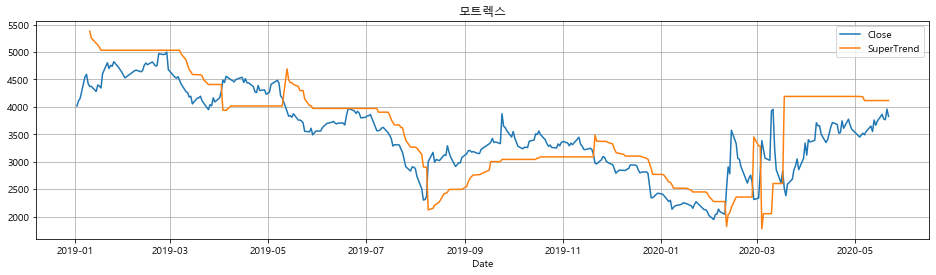

In [9]:
name = '모트렉스'
df = select_stock(name,'2019-01-01')
ST(df,3,7)
df = df.set_index(df['Date'])
df[['Close','SuperTrend']].plot(figsize=(16,4))
plt.title(name)
plt.grid(True)
plt.show()    


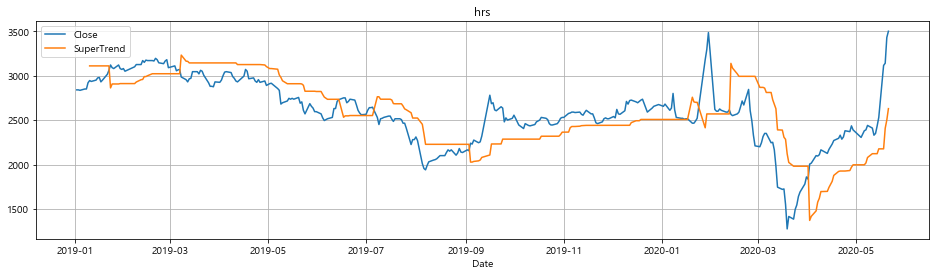

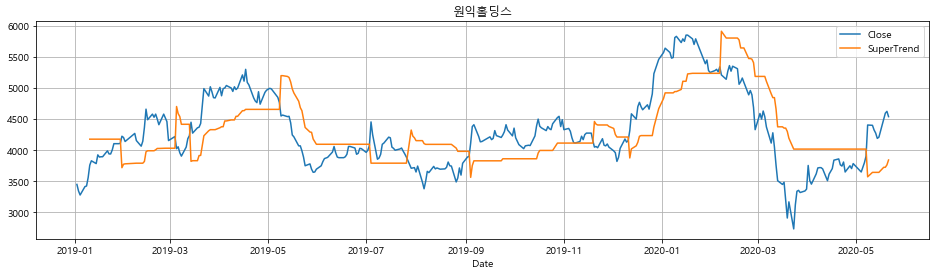

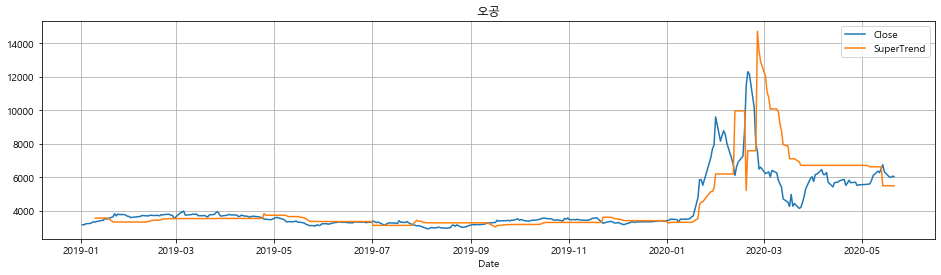

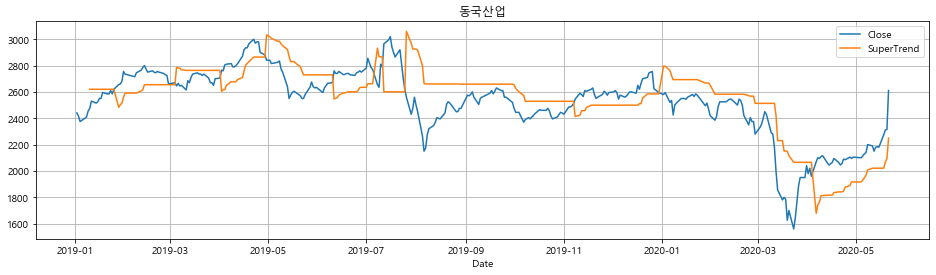

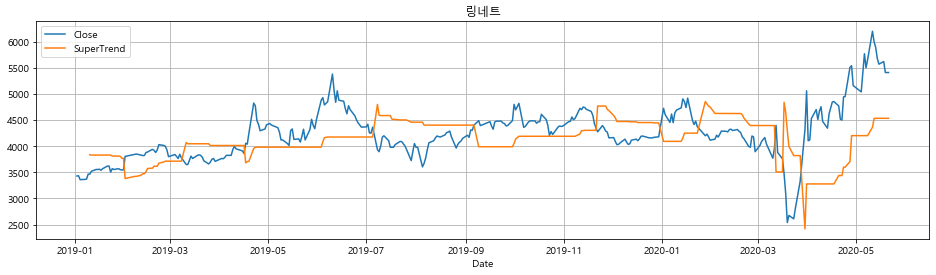

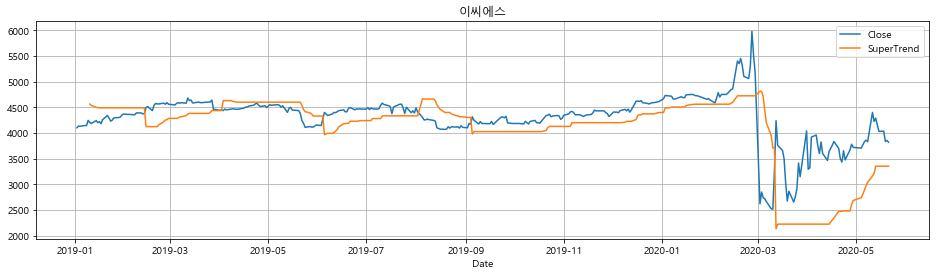

In [12]:
#df = pd.read_excel('d:\\stockdata\\vote_stock\\detect_stock_with_price_2020-05-18.xlsx')
#df = pd.read_excel('d:\\high.xlsx')
#df = df['Name'].unique()
#name = df.values.tolist() ## numpy to list
#name = df.tolist()  

name = ['hrs','원익홀딩스','오공','동국산업','링네트','이씨에스']

for i in name:
    df = select_stock(i,'2019-01-01')
    df['V']=df['Volume']
    ST(df,3,7)
    df = df.set_index(df['Date'])
    df[['Close','SuperTrend']].plot(figsize=(16,4))
    plt.title(i)
    plt.grid(True)
    plt.show()    



In [10]:
df = select_stock('hrs','2020-05-01')
df

,Date,Code,Name,Open,High,Low,Volume,Close
0,2020-05-04,036640,HRS,2350,2375,2265,122492,2305
1,2020-05-06,036640,HRS,2320,2385,2320,83658,2380
2,2020-05-07,036640,HRS,2390,2395,2355,57998,2390
3,2020-05-08,036640,HRS,2395,2450,2380,106882,2440
4,2020-05-11,036640,HRS,2475,2475,2405,60395,2410
5,2020-05-12,036640,HRS,2415,2420,2300,145793,2330
6,2020-05-13,036640,HRS,2295,2355,2295,40854,2350
7,2020-05-14,036640,HRS,2305,2510,2305,343192,2435
8,2020-05-15,036640,HRS,2460,2815,2460,2509789,2530
9,2020-05-18,036640,HRS,2545,3180,2520,5858871,3115


In [ ]:
var = "select * from kospi where Date > '2018-01-01'"
df = pd.read_sql(var, engine)


ST(df,3,7)
df = df.set_index(df['Date'])
df[['Close','SuperTrend']].plot(figsize=(16,4))
plt.title('kospi')
plt.grid(True)
plt.show()

In [ ]:
var = "select * from kosdaq where Date > '2018-01-01'"
df = pd.read_sql(var, engine)


ST(df,3,7)
df = df.set_index(df['Date'])
df[['Close','SuperTrend']].plot(figsize=(16,4))
plt.title('kosdaq')
plt.grid(True)
plt.show()

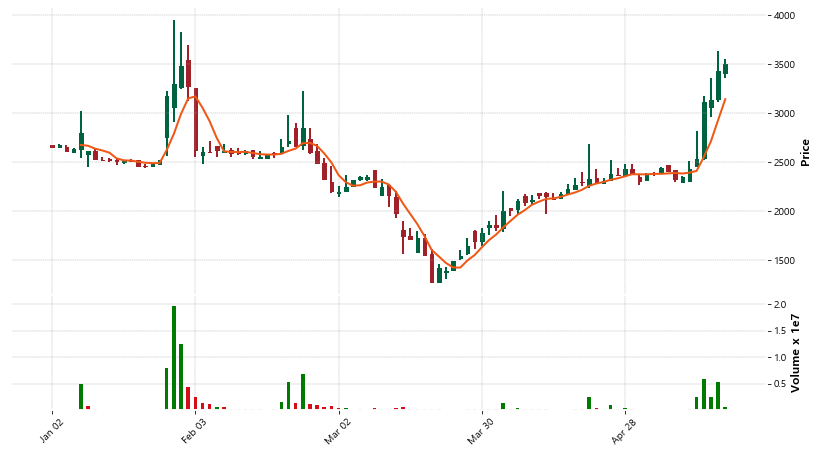

In [3]:
from mod1 import *
import matplotlib.gridspec as gridspec
import mplfinance as mpf


df = select_stock('hrs', '2020-01-01')

ohlc = df[['Date','Open', 'High', 'Low', 'Close','Volume']]
ohlc['Date'] = pd.to_datetime(ohlc['Date'])
ohlc = ohlc.set_index('Date')
ohlc.index.name = 'Date'

mpf.plot(ohlc,figratio=(15,8),type='candle',mav=(5),volume=True,style='charles')  ### 3,6,9일 이동평균선 그리고 거래량

# 데이타 전처리

## MinMaxScaler

In [ ]:
from mod1 import *

df = select_stock('hrs','2020-01-01')
df = df[['Open','High','Low','Volume','Close']]
print(df.head())

# 결과확인을 위해 소수 출력 옵션 변경 소수 첫째자리까지
np.set_printoptions(formatter={'float_kind': lambda x: "{0:0.5f}".format(x)}) 

data = df.values

scaler = MinMaxScaler()

data_a =scaler.fit_transform(data)               ## 전처리 
print(data_a[:5])

data_b = scaler.inverse_transform(data_a)        ## 전체 복원
print(data_b[:5])

data_c = scaler.inverse_transform(data_a)[:, [0]] ##  Open열만 복원,  Close열은 [4]
data_c[:5]

### 주식 예측값 배열이 생성 되었을때 실제 Close와 비교하기

#pred = model.predict(test_X) 
pred = [[0.69005],[0.61538],[0.60407],[0.63575],[0.62443]]  ## 테스트용으로 종가 5일치를 역순으로 
scale= MinMaxScaler()
scale.min_, scale.scale_=scaler.min_[4], scaler.scale_[4]   ##  Open열[0],High열[1] ~ Close열은 [4]
data_d = scale.inverse_transform(pred)
print(data_d)

In [ ]:
import numpy as np
print(np.__version__) # 1.16.4

# 결과확인을 위해 소수 출력 옵션 변경
np.set_printoptions(formatter={'float_kind': lambda x: "{0:0.1f}".format(x)}) 

from sklearn.preprocessing import MinMaxScaler

t1 =  np.array([
                    [ 1,    1000],
                    [ 5,   10000],
                    [10,  100000],
               ])
t2 =  np.array([
                    [  2,    100],
                    [ 15,  20000],
                    [100, 300000],
               ])

scaler = MinMaxScaler()

scaler.fit(t1)
print(scaler.n_samples_seen_, scaler.data_min_, scaler.data_max_, scaler.feature_range)
# > 3 [1.0 1000.0] [10.0 100000.0] (0, 1)

scaler.partial_fit(t2) # 추가 피팅
print(scaler.n_samples_seen_, scaler.data_min_, scaler.data_max_, scaler.feature_range)
# > 6 [1.0 100.0] [100.0 300000.0] (0, 1)

t2_prinme = scaler.transform(t2)
# array([[0.0, 0.0],
#        [0.1, 0.1],
#        [1.0, 1.0]])
print(t2_prinme)

t2_prime_prime = scaler.inverse_transform(t2_prinme)
#  array([[  2.0,    100.0],
#         [ 15.0,  20000.0],
#         [100.0, 300000.0]])
print(t2_prime_prime)


### https://m.blog.naver.com/PostView.nhn?blogId=wideeyed&logNo=221614354947&proxyReferer=https:%2F%2Fwww.google.com%2F

## np.reshape

In [ ]:
##  reshape(-1)의 의미  : 가변적이다

x = np.arange(12)
print(x)

print(x.reshape(-1,1))  ## 행,열중 열이  1열이므로 12행이된다
print(x.reshape(-1,2))  ## 열이 2열이므로 6행이 된다

print(x.reshape(1,-1))  ## 행,열중 행이 1행이므로 열이 12열이 된다
print(x.reshape(2,-1))  ## 행,열중 행이 2행이므로 열이 6열이 된다

## 년중 특정요일 날짜 추출하기

In [ ]:
import pandas as pd

def allsundays(year):
    return pd.date_range(start=str(year), end=str(year+1),freq='W-SUN').strftime('%Y-%m-%d').tolist()

allsundays(2020)[:5]  # First 5 Sundays of 2020
# ['01/01/2017', '01/08/2017', '01/15/2017', '01/22/2017', '01/29/2017']


https://rfriend.tistory.com/503

In [ ]:
from datetime import date, timedelta

def allsundays(year):
   d = date(year, 1, 1)                    # January 1st
   d += timedelta(days = 6 - d.weekday())  # First Sunday
   while d.year == year:
      yield d
      d += timedelta(days = 7)

sunday=[]    
for d in allsundays(2020):
   sunday.append(d)

sunday[0]